In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import hilbert, resample
from scipy.ndimage import uniform_filter1d
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr, spearmanr, sem, entropy, skew
from sklearn.metrics import mean_squared_error
from pydub import AudioSegment
from MFDFA import MFDFA
import random
import seaborn as sns
import json
import ast
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

def apply_black_box(ax=None):
    """Apply black border box and tidy formatting to a matplotlib Axes."""
    import matplotlib.pyplot as plt

    if ax is None:
        ax = plt.gca()

    # Enable all spines and set them to black
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color("black")

    # Optional: other default styling
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    
    
def save_plot(base_path, dpi=600):
    # Ensure directory exists
    os.makedirs(os.path.dirname(base_path), exist_ok=True)

    # Save as PDF (vector quality, best for LaTeX/Overleaf)
    plt.savefig(f"{base_path}.pdf", bbox_inches='tight')

    # Save as PNG (high-res raster, useful for slides/web)
    plt.savefig(f"{base_path}.png", dpi=dpi, bbox_inches='tight')

# The Evolution of Music Structure from a Fractal Perspective using MFDFA

## 1 Per-song Spectrum
Metrics to pay attention for:
- ΔH (delta_H) is the difference between max and min H(q). It shows the degree of multifractality where higher ΔH means more complex scaling and variability
- α-width is the Width of multifractal spectrum (hq_max - hq_min). Broader spectrum suggests richer textural/structural variability
- Spectrum Skew is the asymmetry of the spectrum (α_skew). 
    - Left skew (positive): Dominance of fine-scale fluctuations (right side compressed). Lots of subtle, soft, detailed variations (e.g., quiet dynamics, small pitch bends)
    - Right skew (negative): Dominance of coarse-scale fluctuations (left side compressed). Larger, more abrupt dynamics or loud transitions
- Right or left truncated: Leveling in H(q) indicates insensitivity to small (left) or large (right) dynamics.

If the amplitude envelope is mostly periodic, smoothed, or exhibits regularity in energy bursts, the analysis may flatten for q > 0, reflecting that:
- Most energy levels fluctuate in similar patterns,
- Large bursts (e.g. beats, drops) aren’t diverse enough across the song,
- Compression or mastering may normalize amplitude peaks.


The shape of the multifractal spectrum does not have to be symmetric. The multifractal spectrum can also have either a left or a right truncation that originate from a leveling of the q-order Hurst exponent for negative or positive q’s, respectively. In this case, the spectrum shows a right truncation.
- Sharp drop in H(q) for positive q indicates leveling of fluctuation behavior across large magnitudes.
- Truncation on right side of multifractal spectrum (narrow or abrupt end) matches right truncation due to flattening of H(q) at positive q.

This means the signal is more sensitive to small fluctuations (negative-q side) and has weaker variability or self-similarity in its larger amplitude structures (positive-q side). This could be due to:
- Musical regularity (repetitive phrasing, sustained notes),
- Low dynamic range, or
- Envelope smoothing effects reducing amplitude peaks.

### 1.1 DFA vs. MFDFA

In [4]:
# === Safe Parser for Potential Stringified Lists ===
def safe_parse_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return x
    return x

from pathlib import Path
REPO_ROOT = Path(os.getcwd()).resolve().parent

# DFA
billboard_dfa = pd.read_csv(REPO_ROOT / "reference_data" / "dfa" / "billboard.csv")
diffrhythm_dfa = pd.read_csv(REPO_ROOT / "reference_data" / "dfa" / "diffrhythm.csv")
suno_dfa = pd.read_csv(REPO_ROOT / "reference_data" / "dfa" / "suno.csv")
yue_dfa = pd.read_csv(REPO_ROOT / "reference_data" / "dfa" / "yue.csv")

for df in [billboard_dfa, suno_dfa, diffrhythm_dfa, yue_dfa]:
    df.rename(columns={"alpha": "dfa_alpha"}, inplace=True)

dfa_data = {
    "BB": billboard_dfa,
    "Suno": suno_dfa,
    "DR": diffrhythm_dfa,
    "YuE": yue_dfa
}

# MFDFA
# q-values [-10,10,42]
billboard = pd.read_csv(REPO_ROOT / "reference_data" / "mfdfa" / "billboard.csv")
diffrhythm = pd.read_csv(REPO_ROOT / "reference_data" / "mfdfa" / "diffrhythm.csv")
suno = pd.read_csv(REPO_ROOT / "reference_data" / "mfdfa" / "suno.csv")
yue = pd.read_csv(REPO_ROOT / "reference_data" / "mfdfa" / "yue.csv")

mfdfa_data = {
    "BB": billboard,
    "Suno": suno,
    "DR": diffrhythm,
    "YuE": yue
}

palette = {
    "BB": sns.color_palette("deep")[0],
    "Suno": sns.color_palette("deep")[1],
    "DR": sns.color_palette("deep")[2],
    "YuE": sns.color_palette("deep")[3],
}

billboard.head()

,year,position,artist,title,alpha,f_alpha,alpha_width,alpha_peak,spectrum_skew,truncation,H_q
0,1950,1,Gordon Jenkins & The Weavers,Goodnight Irene,"[1.2285439901864306, 1.2294857516780842, 1.231...","[0.24739768291955855, 0.25635590198650604, 0.2...",1.542733,1.517520,0.625372,left,"[2.627701676406446, 2.625229795897371, 2.62253..."
1,1950,2,Nat King Cole,Mona Lisa,"[1.0824994428817298, 1.0827827816728803, 1.083...","[0.06967797596900027, 0.07237314983604115, 0.0...",3.347960,3.427905,-0.401096,right,"[3.4969138060505878, 3.5003816809850643, 3.504..."
2,1950,3,Anton Karas,Third Man Theme,"[1.0349541059723528, 1.0358010555609454, 1.037...","[0.3898995752989194, 0.3979559250440676, 0.414...",2.818727,1.353219,0.774179,left,"[3.6993751799531926, 3.6935093900123546, 3.686..."
3,1950,4,Gary & Bing Crosby,Sam's Song,"[1.007418315443542, 1.0077798586854287, 1.0086...","[-0.11394036149650866, -0.11050129163465883, -...",1.964069,1.450505,0.548808,left,"[2.8281879526548424, 2.824856015245572, 2.8210..."
4,1950,5,Gary & Bing Crosby,Simple Melody,"[1.118463478104023, 1.1190648287768021, 1.1204...","[0.14760086142646855, 0.15332102636265965, 0.1...",1.818879,1.485181,0.596765,left,"[2.8168412756697334, 2.813417436031349, 2.8095..."


In [ ]:
# Adjust merge keys to avoid 'artist' if it's missing
results = []

for model in ["BB", "Suno", "DR", "YuE"]:
    dfa_df = dfa_data.copy()[model]
    mfdfa_df = mfdfa_data.copy()[model]

    # Determine common columns for merging
    merge_keys = [col for col in ["year", "position", "artist", "title"] if col in dfa_df.columns and col in mfdfa_df.columns]

    merged_df = pd.merge(dfa_df, mfdfa_df, on=merge_keys)
    merged_df = merged_df.dropna(subset=["dfa_alpha", "alpha_peak", "alpha", "alpha_width"])

    # Convert alpha list string to actual list
    merged_df["alpha"] = merged_df["alpha"].apply(safe_parse_list)
    
    dfa_alpha = merged_df["dfa_alpha"].astype(float)
    alpha_peak = merged_df["alpha_peak"].astype(float)
    alpha_mean = merged_df["alpha"].apply(lambda x: sum(x)/len(x))
    alpha_width = merged_df["alpha_width"].astype(float)

    for label, mfdfa_metric in [("α_peak", alpha_peak), ("α_mean", alpha_mean), ("α_width", alpha_width)]:
        pearson_r, _ = pearsonr(dfa_alpha, mfdfa_metric)
        spearman_rho, _ = spearmanr(dfa_alpha, mfdfa_metric)
        mean_bias = (dfa_alpha - mfdfa_metric).mean()

        results.append({
            "Model": model,
            "Metric": label,
            "Pearson r": round(pearson_r, 3),
            "Spearman ρ": round(spearman_rho, 3),
            "Mean Bias (DFA − MFDFA)": round(mean_bias, 3)
        })

results_df = pd.DataFrame(results)
results_df

,Model,Metric,Pearson r,Spearman ρ,Mean Bias (DFA − MFDFA)
0,BB,α_peak,0.107,0.400,-0.486
1,BB,α_mean,0.196,0.228,-0.748
2,BB,α_width,-0.052,-0.037,-0.708
3,Suno,α_peak,0.246,0.650,-0.473
4,Suno,α_mean,0.275,0.252,-0.790
5,Suno,α_width,-0.075,-0.146,-0.772
6,DR,α_peak,0.531,0.836,-0.296
7,DR,α_mean,0.459,0.462,-0.621
8,DR,α_width,-0.357,-0.353,-0.517
9,YuE,α_peak,0.187,0.683,-0.287


🎵 Selected Song: If I Ain't Got You – Alicia Keys (2004, Rank 3)

BB → α width: 1.8972, α peak: 1.3856 skew: 0.0433
Suno → α width: 1.9404, α peak: 1.5077 skew: 0.0188
DR → α width: 1.4993, α peak: 1.3298 skew: 0.0471
YuE → α width: 1.9223, α peak: 1.4094 skew: 0.0414


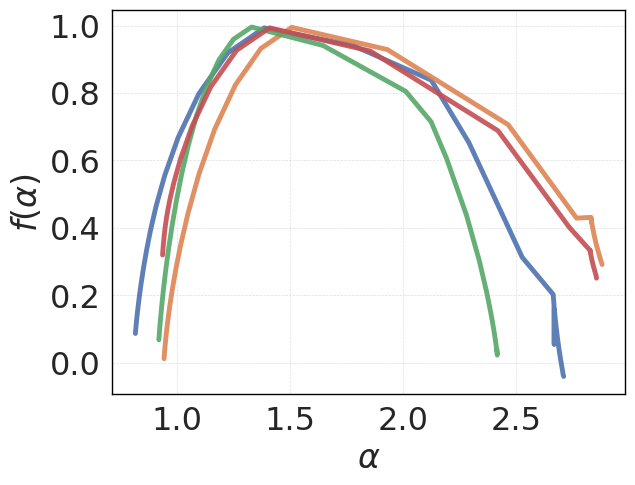

In [ ]:
# # === Step 1: Sample a valid (year, position) pair from Billboard ===
# valid_pairs = billboard[["year", "position"]].drop_duplicates()
# sample = valid_pairs.sample(1).iloc[0]
# year, pos = sample["year"], sample["position"]

# # === Step 2: Get title and artist ===
# match = billboard[(billboard["year"] == year) & (billboard["position"] == pos)].iloc[0]
# title = match["title"]
# artist = match["artist"]

year = 2004
title = "If I Ain't Got You"
artist = "Alicia Keys"
pos = '3'

print(f"🎵 Selected Song: {title} – {artist} ({year}, Rank {pos})\n")

# === Step 3: Plot and print descriptors ===
plt.figure(figsize=(6.5, 5))

for model, df in mfdfa_data.items():
    try:
        row = df[(df["year"] == year) & (df["position"] == pos)].iloc[0]
        alpha = safe_parse_list(row["alpha"])
        f_alpha = safe_parse_list(row["f_alpha"])
        
        if isinstance(alpha, list) and isinstance(f_alpha, list):
            # Plot
            plt.plot(alpha, f_alpha, label=model, color=palette[model], linewidth=3.5, alpha=.9, linestyle="solid")

            # Descriptors
            alpha_width = max(alpha) - min(alpha)
            alpha_peak = alpha[f_alpha.index(max(f_alpha))]
            spectrum_skew = skew(alpha, bias=False)

            print(f"{model} → α width: {alpha_width:.4f}, α peak: {alpha_peak:.4f} skew: {spectrum_skew:.4f}")
    except IndexError:
        print(f"⚠️ {model} has no match for ({year}, {pos})")

plt.xlabel(r"$\alpha$", fontsize=24)
plt.ylabel(r"$f(\alpha)$", fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=23)

plt.grid(True, linestyle="--", linewidth=0.75, alpha=0.6)
sns.despine()
apply_black_box()
plt.tight_layout()
plt.show()

Across all models and descriptors, the correlations are generally low (r ≈ 0.1 to 0.4), which suggests:
- DFA α does not align strongly with any specific MFDFA descriptor (α_peak, α_mean, or α_width).
- Spearman ρ values also show weak monotonic relationships, confirming a general lack of structured association.

This implies that DFA α and MFDFA-derived metrics capture fundamentally different properties of the signal.

## 2 How does AI Compare to the Evolution of the Top 5 Billboard Music?

### 2.1 Joint Density Distribution of $\alpha$ and $f(\alpha)$
Visualizations of each distribution for all-time and by decade. Each distribution is compared to the Billboard distribution with JSD.

In [10]:
# === Expand MFDFA data into long format for joint density plotting ===
def expand_mfdfa_data(df, model_name):
    df = df.copy()
    df = df.dropna(subset=["alpha", "f_alpha", "year"])
    df["alpha"] = df["alpha"].apply(json.loads)
    df["f_alpha"] = df["f_alpha"].apply(json.loads)
    df["decade"] = (df["year"] // 10) * 10

    records = []
    for _, row in df.iterrows():
        for a, f in zip(row["alpha"], row["f_alpha"]):
            records.append({
                "alpha": a,
                "f_alpha": f,
                "year": row["year"],
                "decade": row["decade"],
                "model": model_name
            })
    return pd.DataFrame(records)

expanded_all_df = pd.concat([
    expand_mfdfa_data(df, model_name) for model_name, df in mfdfa_data.items()
], ignore_index=True)


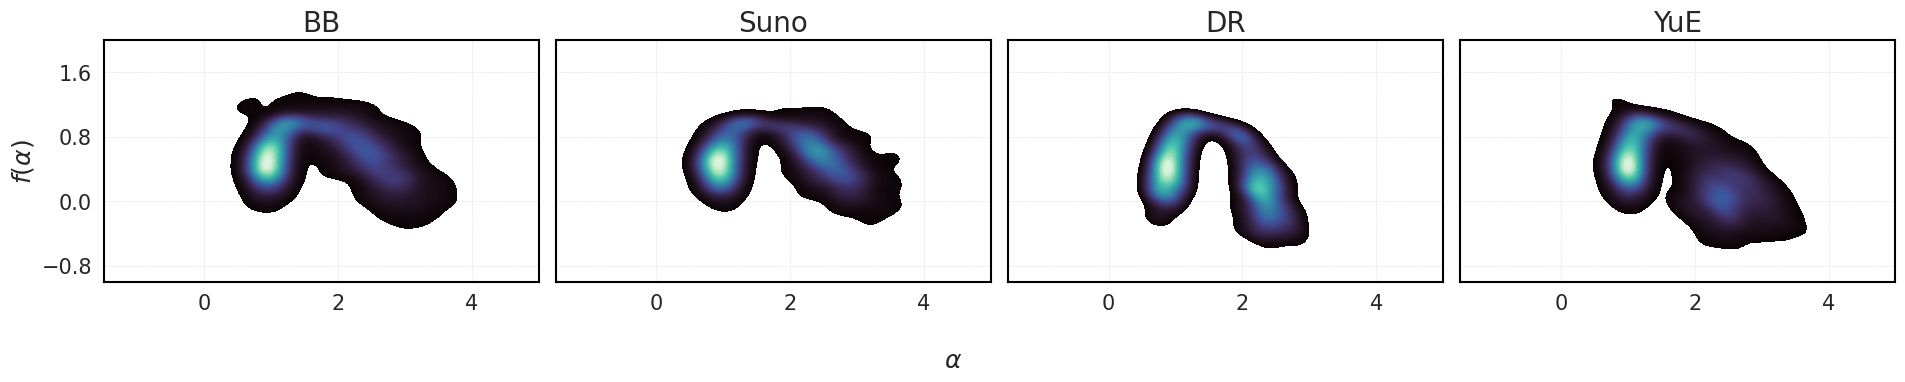

In [ ]:
alpha_lim = (-1.5, 5.0)
f_alpha_lim = (-1.0, 2.0)

# Count number of unique models for column layout
n_models = expanded_all_df["model"].nunique()

# === Joint Density Plot in Single Row ===
g = sns.FacetGrid(
    expanded_all_df,
    col="model",
    col_wrap=None,  # Ensure all in one row
    height=4,
    aspect=1.2,
    sharex=True,
    sharey=True
)

g.map_dataframe(
    sns.kdeplot,
    x="alpha",
    y="f_alpha",
    fill=True,
    thresh=0.05,
    cmap="mako",
    levels=100
)

# Set limits and grid
for ax in g.axes.flat:
    ax.set_xlim(alpha_lim)
    ax.set_ylim(f_alpha_lim)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5, zorder=0)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))

    # Draw black border
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(1.5)

# Labeling
g.set_axis_labels("", r"$f(\alpha)$", size=18)
g.set_titles("{col_name}", size=20)
g.fig.supxlabel(r"$\alpha$", fontsize=18, y=0.05)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for shared xlabel
plt.show()

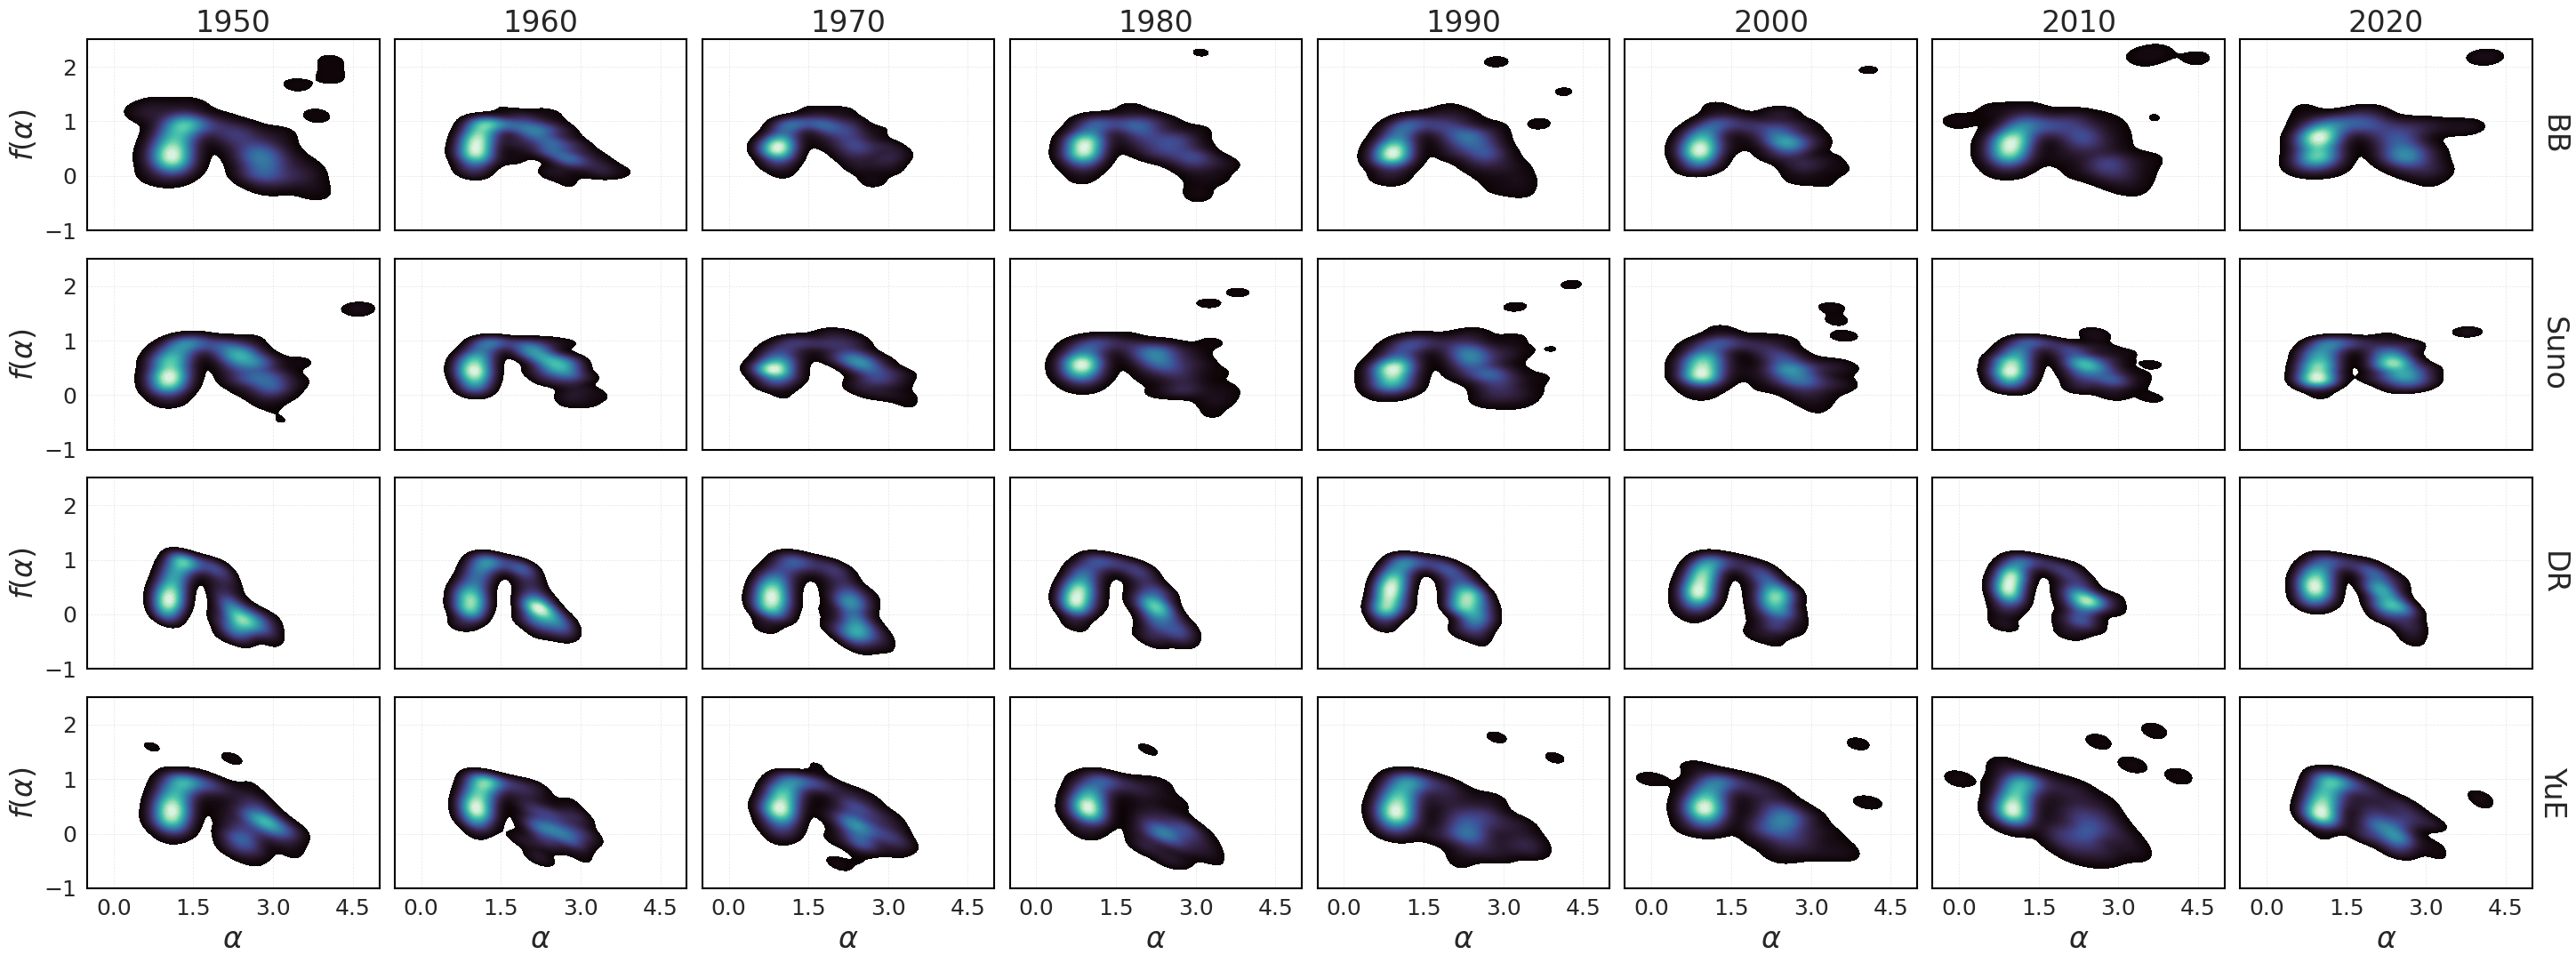

In [ ]:
# Define common limits (adjust if needed)
alpha_lim = (-0.5, 5.0)
f_alpha_lim = (-1.0, 2.5)

# === Plot joint density by model and decade ===
# Create the FacetGrid with row as model and column as decade
g2 = sns.FacetGrid(
    expanded_all_df,
    col="decade",
    row="model",
    height=2.8,
    aspect=1.3,
    margin_titles=True,
    sharex=True,
    sharey=True
)

g2.map_dataframe(
    sns.kdeplot,
    x="alpha",
    y="f_alpha",
    fill=True,
    thresh=0.05,
    cmap="mako",
    levels=100
)

# Format each subplot
for ax in g2.axes.flat:
    ax.set_xlim(alpha_lim)
    ax.set_ylim(f_alpha_lim)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5, zorder=0)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(1.5)

# Add labels and titles
g2.set_axis_labels(r"$\alpha$", r"$f(\alpha)$", size=24)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [12]:
# We'll reuse the compute_joint_jsd function from earlier
def compute_joint_jsd(df1, df2, bins=100, range_alpha=(-0.5, 3.0), range_falpha=(-0.5, 1.5), epsilon=1e-10):
    if df1.empty or df2.empty:
        return np.nan

    H1, _, _ = np.histogram2d(df1["alpha"], df1["f_alpha"], bins=bins, range=[range_alpha, range_falpha], density=False)
    H2, _, _ = np.histogram2d(df2["alpha"], df2["f_alpha"], bins=bins, range=[range_alpha, range_falpha], density=False)

    P = H1.flatten().astype(float) + epsilon
    Q = H2.flatten().astype(float) + epsilon

    P_sum = P.sum()
    Q_sum = Q.sum()
    if P_sum == 0 or Q_sum == 0:
        return np.nan

    P /= P_sum
    Q /= Q_sum

    return jensenshannon(P, Q, base=2.0)**2

# Flatten spectra to long-form DataFrame
def flatten_spectrum(df):
    df = df.dropna(subset=["alpha", "f_alpha", "year"])
    df["alpha"] = df["alpha"].apply(safe_parse_list)
    df["f_alpha"] = df["f_alpha"].apply(safe_parse_list)
    df["decade"] = (df["year"] // 10) * 10

    rows = []
    for _, row in df.iterrows():
        alphas = row["alpha"]
        f_alphas = row["f_alpha"]
        if isinstance(alphas, list) and isinstance(f_alphas, list):
            for a, f in zip(alphas, f_alphas):
                rows.append({
                    "alpha": a,
                    "f_alpha": f,
                    "year": row["year"],
                    "decade": row["decade"],
                    "model": row["model"]
                })
    return pd.DataFrame(rows)

def preprocess_mfdfa_data(mfdfa_data):
    processed = {}
    for model, df in mfdfa_data.items():
        df = df.copy()
        df["alpha"] = df["alpha"].apply(safe_parse_list)
        df["f_alpha"] = df["f_alpha"].apply(safe_parse_list)
        df["model"] = model
        df["decade"] = (df["year"] // 10) * 10
        processed[model] = df
    return processed

def flatten_all_mfdfa_data(mfdfa_data):
    return pd.concat([flatten_spectrum(df) for df in mfdfa_data.values()], ignore_index=True)

def compute_jsd_matrix(df_all, reference_model="BB"):
    models = [m for m in df_all["model"].unique() if m != reference_model]
    decades = sorted(df_all["decade"].dropna().unique())

    all_time_jsd = {
        model: compute_joint_jsd(
            df_all[df_all["model"] == reference_model],
            df_all[df_all["model"] == model]
        ) for model in models
    }

    decade_jsd = {
        model: {
            decade: compute_joint_jsd(
                df_all[(df_all["model"] == reference_model) & (df_all["decade"] == decade)],
                df_all[(df_all["model"] == model) & (df_all["decade"] == decade)]
            ) for decade in decades
        } for model in models
    }

    all_time_jsd_df = pd.DataFrame([
        {"Model": model, "All Time": jsd} for model, jsd in all_time_jsd.items()
    ])

    decade_jsd_df = pd.DataFrame(decade_jsd).T
    decade_jsd_df["Model"] = decade_jsd_df.index
    decade_jsd_df.reset_index(drop=True, inplace=True)

    return all_time_jsd_df.merge(decade_jsd_df, on="Model")

In [ ]:
processed_mfdfa_data = preprocess_mfdfa_data(mfdfa_data.copy())
df_all = flatten_all_mfdfa_data(processed_mfdfa_data)
final_jsd_df = compute_jsd_matrix(df_all, reference_model="BB")
final_jsd_df

,Model,All Time,1950,1960,1970,1980,1990,2000,2010,2020
0,Suno,0.198642,0.498604,0.507000,0.558309,0.532862,0.459724,0.505737,0.545616,0.687757
1,DR,0.393381,0.588079,0.636432,0.680402,0.670692,0.587584,0.615467,0.581055,0.713330
2,YuE,0.310017,0.483365,0.543880,0.551004,0.587713,0.567036,0.634961,0.589605,0.734742


In [14]:
for df in [billboard, suno, diffrhythm, yue]:
    df["alpha"] = df["alpha"].apply(safe_parse_list)
    df["f_alpha"] = df["f_alpha"].apply(safe_parse_list)

# Function to compute JSD against Billboard mean spectrum
def compute_jsd_against_mean(df, model_name):
    results = []
    for i, row in df.iterrows():
        a = np.array(row["alpha"])
        f = np.array(row["f_alpha"])
        f_interp = np.interp(alpha_grid, a, f, left=0, right=0)

        epsilon = 1e-10
        P = np.clip(f_interp, 0, None) + epsilon
        Q = np.clip(f_alpha_billboard_mean, 0, None) + epsilon
        P /= P.sum()
        Q /= Q.sum()
        M = 0.5 * (P + Q)
        jsd = 0.5 * (entropy(P, M, base=2) + entropy(Q, M, base=2))

        results.append({
            "model": model_name,
            "title": row["title"],
            "artist": row["artist"],
            "year": row["year"],
            "JSD_vs_Billboard": jsd
        })
    return pd.DataFrame(results)

In [ ]:
# Interpolate all Billboard spectra to a common alpha grid
alpha_arrays = billboard["alpha"].tolist()
f_alpha_arrays = billboard["f_alpha"].tolist()
alpha_grid = np.linspace(-0.5, 3.0, 200)
f_alpha_interp_list = []

for a, f in zip(alpha_arrays, f_alpha_arrays):
    interp = np.interp(alpha_grid, a, f, left=0, right=0)
    f_alpha_interp_list.append(interp)

f_alpha_billboard_mean = np.mean(f_alpha_interp_list, axis=0)

# Apply to AI models
jsd_suno = compute_jsd_against_mean(suno, "Suno")
jsd_diff = compute_jsd_against_mean(diffrhythm, "DiffRhythm")
jsd_yue = compute_jsd_against_mean(yue, "YuE")
all_jsd_df = pd.concat([jsd_suno, jsd_diff, jsd_yue], ignore_index=True)

# Extract best/worst matches
summary_rows = []
for model in all_jsd_df["model"].unique():
    model_df = all_jsd_df[(all_jsd_df["model"] == model) & all_jsd_df["JSD_vs_Billboard"].notna()]
    if not model_df.empty:
        best = model_df.loc[model_df["JSD_vs_Billboard"].idxmin()]
        worst = model_df.loc[model_df["JSD_vs_Billboard"].idxmax()]
        summary_rows.append({
            "Model": model, "Type": "Best",
            "Title": best["title"], "Artist": best["artist"],
            "Year": best["year"], "JSD_vs_Billboard": best["JSD_vs_Billboard"]
        })
        summary_rows.append({
            "Model": model, "Type": "Worst",
            "Title": worst["title"], "Artist": worst["artist"],
            "Year": worst["year"], "JSD_vs_Billboard": worst["JSD_vs_Billboard"]
        })

summary_df = pd.DataFrame(summary_rows)
summary_df

,Model,Type,Title,Artist,Year,JSD_vs_Billboard
0,Suno,Best,End of the Road,Boyz II Men,1992,0.007346
1,Suno,Worst,Hot in Herre,Nelly,2002,0.451773
2,DiffRhythm,Best,Bad Guy,Billie Eilish,2019,0.012820
3,DiffRhythm,Worst,Hanging By A Moment,Lifehouse,2001,0.341727
4,YuE,Best,Uptown Funk,Mark Ronson feat. Bruno Mars,2015,0.009888
5,YuE,Worst,Straight Up,Paula Abdul,1989,0.771801


### 2.2 Descriptor Evolution ($\alpha$-peak, $\alpha$-width, and skew)

/tmp/ipykernel_402393/713092122.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_all, x="Model", y=metric, palette=palette,
/tmp/ipykernel_402393/713092122.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_all, x="Model", y=metric, palette=palette,
/tmp/ipykernel_402393/713092122.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_all, x="Model", y=metric, palette=palette,


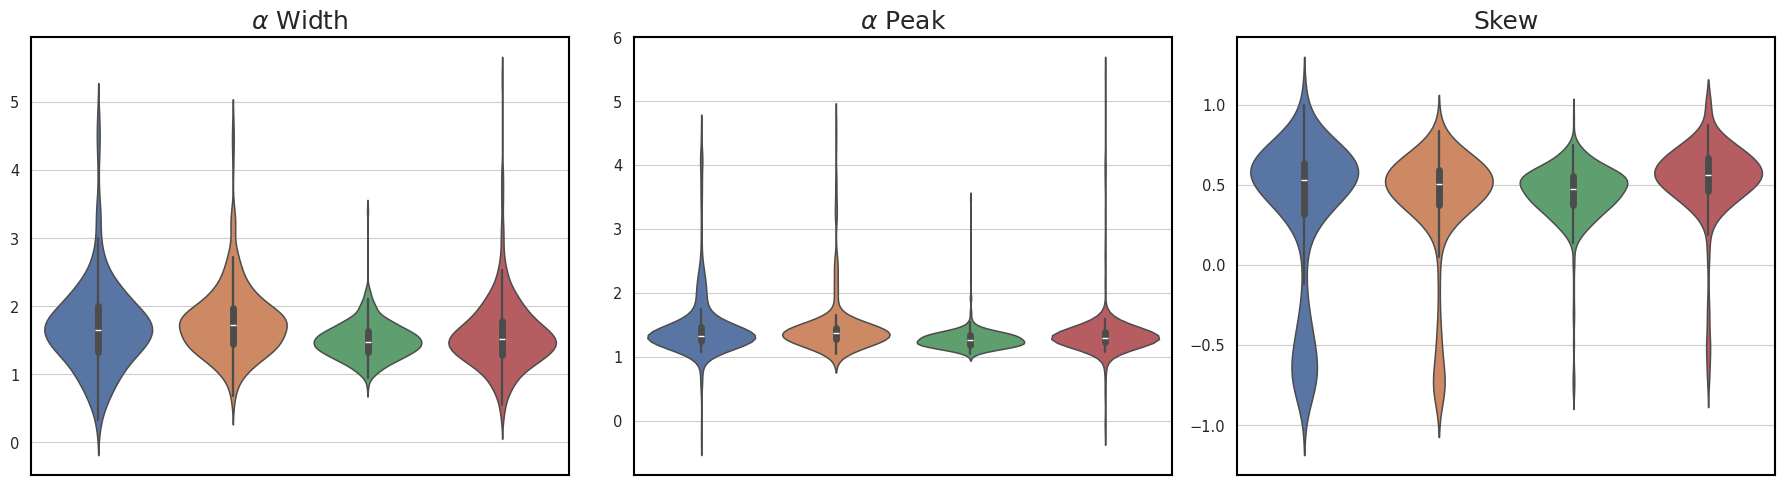

In [ ]:
# === Combine Data ===
for name, df in [("BB", billboard), ("Suno", suno),
                 ("DR", diffrhythm), ("YuE", yue)]:
    df["Model"] = name

df_all = pd.concat([billboard, suno, diffrhythm, yue], ignore_index=True)

# === Prepare for subplots ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Titles
titles = [r"$\alpha$ Width", r"$\alpha$ Peak", "Skew"]

# Plot each metric
metrics = ["alpha_width", "alpha_peak", "spectrum_skew"]
for ax, metric, title in zip(axes, metrics, titles):
    sns.violinplot(data=df_all, x="Model", y=metric, palette=palette,
                   inner="box", linewidth=1.1, ax=ax)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("")
    ax.set_xticklabels([])  # Remove model names
    ax.set_ylabel("")

    # Black border on all sides
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(1.5)

# === Final Formatting ===
# sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
# Extract only relevant columns
features = ["alpha_width", "alpha_peak", "spectrum_skew"]

# Compute detailed summary statistics
summary_stats = {}
for name, df in mfdfa_data.copy().items():
    stats = df[features].agg(["mean", "std", "min", "max", "skew", "kurtosis"]).T
    stats["range"] = stats["max"] - stats["min"]  # Add range
    stats["Model"] = name
    # Reorder columns to place 'range' after 'max'
    cols_order = ["mean", "std", "min", "max", "range", "skew", "kurtosis", "Model"]
    stats = stats[cols_order]

    summary_stats[name] = stats

# Concatenate into a single DataFrame
summary_df = pd.concat(summary_stats.values())
summary_df = summary_df.set_index(["Model"], append=True).reorder_levels(["Model", None])
summary_df = summary_df.round(3)
summary_df

mean    std    min    max  range   skew  kurtosis
Model                                                                  
BB    alpha_width    1.702  0.661  0.218  4.874  4.656  1.357     4.483
      alpha_peak     1.482  0.526 -0.213  4.468  4.680  3.152    12.644
      spectrum_skew  0.325  0.492 -0.888  1.000  1.888 -1.263     0.123
Suno  alpha_width    1.770  0.532  0.590  4.716  4.126  1.683     6.043
      alpha_peak     1.471  0.474  1.046  4.678  3.631  4.045    18.590
      spectrum_skew  0.388  0.374 -0.846  0.833  1.680 -2.173     3.857
DR    alpha_width    1.499  0.266  0.837  3.399  2.563  1.206     6.286
      alpha_peak     1.279  0.168  1.046  3.467  2.421  6.637    78.219
      spectrum_skew  0.449  0.186 -0.787  0.924  1.711 -2.758    14.206
YuE   alpha_width    1.583  0.529  0.382  5.334  4.952  2.026     9.666
      alpha_peak     1.361  0.429 -0.106  5.425  5.532  5.142    38.273
      spectrum_skew  0.530  0.255 -0.729  1.000  1.729 -2.491     8.827

/tmp/ipykernel_402393/2058439963.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.errorbar(summary_stats["decade"], summary_stats["alpha_width_mean"],
/tmp/ipykernel_402393/2058439963.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(summary_stats["decade"], summary_stats["alpha_width_mean"],
/tmp/ipykernel_402393/2058439963.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--s" (-> linestyle='--'). The keyword argument will take precedence.
  ax1.errorbar(summary_stats["decade"], summary_stats["alpha_peak_mean"],
/tmp/ipykernel_402393/2058439963.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "--s" (-> marker='s')

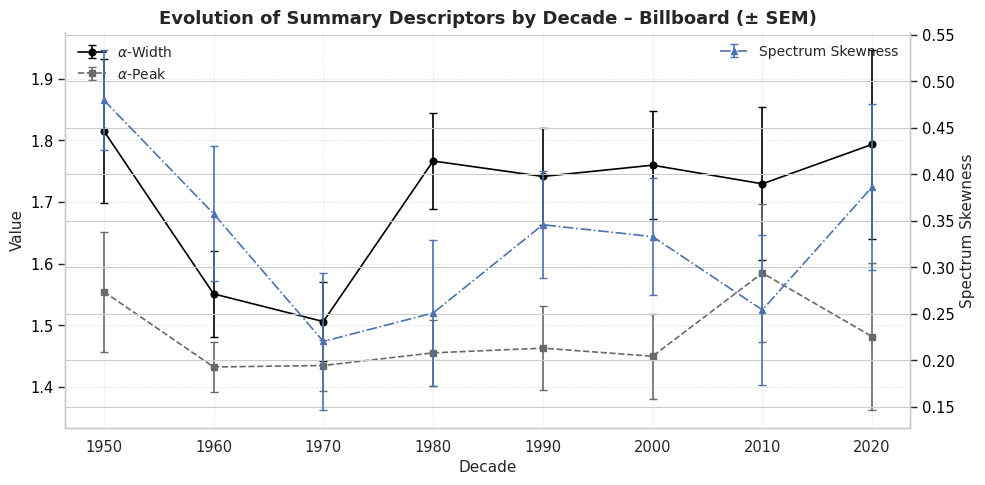

In [ ]:
# === Compute Summary Statistics ===
billboard["year"] = billboard["year"].astype(int)
billboard["decade"] = (billboard["year"] // 10) * 10

summary_stats = billboard.groupby("decade").agg(
    alpha_width_mean=("alpha_width", "mean"),
    alpha_width_sem=("alpha_width", sem),
    alpha_peak_mean=("alpha_peak", "mean"),
    alpha_peak_sem=("alpha_peak", sem),
    spectrum_skew_mean=("spectrum_skew", "mean"),
    spectrum_skew_sem=("spectrum_skew", sem)
).reset_index()

# === Plot ===
fig, ax1 = plt.subplots(figsize=(10, 5))

# Left axis: α-width and α-peak
ax1.errorbar(summary_stats["decade"], summary_stats["alpha_width_mean"],
             yerr=summary_stats["alpha_width_sem"], fmt="-o", capsize=3,
             label=r"$\alpha$-Width", color="black", marker="o", linestyle="-")

ax1.errorbar(summary_stats["decade"], summary_stats["alpha_peak_mean"],
             yerr=summary_stats["alpha_peak_sem"], fmt="--s", capsize=3,
             label=r"$\alpha$-Peak", color="dimgray", marker="s", linestyle="--")

ax1.set_xlabel("Decade", fontsize=11)
ax1.set_ylabel("Value", fontsize=11)
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc="upper left", frameon=False, fontsize=10)
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# Right axis: spectrum skewness
ax2 = ax1.twinx()
ax2.errorbar(summary_stats["decade"], summary_stats["spectrum_skew_mean"],
             yerr=summary_stats["spectrum_skew_sem"], fmt="-.^", capsize=3,
             label="Spectrum Skewness", marker="^", linestyle="-.")

ax2.set_ylabel("Spectrum Skewness", fontsize=11)
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc="upper right", frameon=False, fontsize=10)

# Title and layout
plt.title("Evolution of Summary Descriptors by Decade – Billboard (± SEM)", fontsize=13, weight="bold")
sns.despine(right=False)
plt.tight_layout()
plt.show()

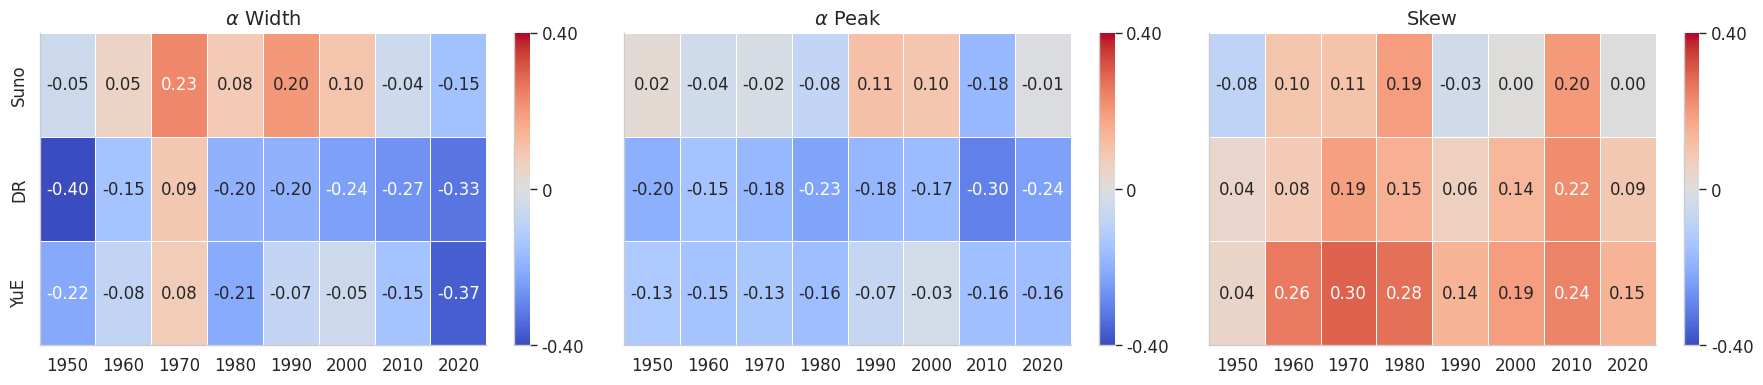

In [ ]:
# === Recompute Decade Columns ===
def add_decade(df):
    df["decade"] = (df["year"] // 10 * 10).astype(int)
    return df

billboard_copy = add_decade(billboard.copy())
suno_copy = add_decade(suno.copy())
diffrhythm_copy = add_decade(diffrhythm.copy())
yue_copy = add_decade(yue.copy())

# === Descriptor Deltas ===
def extract_descriptor_by_decade(df, descriptor):
    return df.groupby("decade")[descriptor].mean()

descriptors = ["alpha_width", "alpha_peak", "spectrum_skew"]
delta_tables = {}

for descriptor in descriptors:
    bb = extract_descriptor_by_decade(billboard_copy, descriptor)
    suno_d = extract_descriptor_by_decade(suno_copy, descriptor) - bb
    diff_d = extract_descriptor_by_decade(diffrhythm_copy, descriptor) - bb
    yue_d = extract_descriptor_by_decade(yue_copy, descriptor) - bb

    delta_table = pd.DataFrame({
        "Suno": suno_d,
        "DR": diff_d,
        "YuE": yue_d
    }).T
    delta_tables[descriptor] = delta_table

# === Symmetric Color Scaling Across All Heatmaps ===
limit = max(abs(df.values).max() for df in delta_tables.values())
vmin, vmax = -limit, limit
ticks = [vmin, 0, vmax]

# === Titles for the 3 Descriptors ===
titles = [r"$\alpha$ Width", r"$\alpha$ Peak", r"Skew"]

# === Plot ===
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

for ax, (desc, data), title in zip(axes, delta_tables.items(), titles):
    heatmap = sns.heatmap(
        data, ax=ax, cmap="coolwarm", center=0, vmin=vmin, vmax=vmax,
        annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 12},
        cbar_kws={"shrink": 1.0}
    )
    
    # Adjust colorbar
    cbar = heatmap.collections[0].colorbar
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{ticks[0]:.2f}", "0", f"{ticks[2]:.2f}"])
    cbar.ax.tick_params(labelsize=12)

    # Format axes
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
import re

# === Helper: Format song label as "Title - Artist (Year, position n)" ===
def create_label(row):
    match = re.match(r"(\d+)", str(row["position"]))
    pos_str = match.group(1) if match else str(row["position"])
    return f"{row['title']} - {row['artist']} ({row['year']}, {pos_str})"

# === Summary extraction function ===
def extract_extremes(df, label):
    df["label"] = df.apply(create_label, axis=1)
    return {
        "Model": label,
        "Max α Width": round(df["alpha_width"].max(), 3),
        "Max α Width Song": df.loc[df["alpha_width"].idxmax(), "label"],
        "Min α Width": round(df["alpha_width"].min(), 3),
        "Min α Width Song": df.loc[df["alpha_width"].idxmin(), "label"],
        "Max Skew": round(df["spectrum_skew"].max(), 3),
        "Max Skew Song": df.loc[df["spectrum_skew"].idxmax(), "label"],
        "Min Skew": round(df["spectrum_skew"].min(), 3),
        "Min Skew Song": df.loc[df["spectrum_skew"].idxmin(), "label"]
    }

# === Compile all model summaries ===
extreme_table = pd.DataFrame([
    extract_extremes(billboard.copy(), "Billboard"),
    extract_extremes(suno.copy(), "Suno"),
    extract_extremes(diffrhythm.copy(), "DiffRhythm"),
    extract_extremes(yue.copy(), "YuE")
])

# === Show table ===
from IPython.display import display
display(extreme_table)

,Model,Max α Width,Max α Width Song,Min α Width,Min α Width Song,Max Skew,Max Skew Song,Min Skew,Min Skew Song
0,Billboard,4.874,"Sugar - Maroon 5 (2015, 5)",0.218,"Dark Horse - Katy Perry and Juicy J (2014, 2)",1.000,"Auf Wiederseh’n Sweetheart - Vera Lynn (1952, 5)",-0.888,"Low - Flo Rida feat. T-Pain (2008, 1)"
1,Suno,4.716,"The Yellow Rose of Texas - Mitch Miller (1955, 3)",0.590,"Hot in Herre - Nelly (2002, 3)",0.833,"Good 4 U - Olivia Rodrigo (2021, 5)",-0.846,Hips Don't Lie - Shakira feat. Wyclef Jean (20...
2,DiffRhythm,3.399,"When I'm Gone - 3 Doors Down (2003, 5)",0.837,"Auf Wiederseh’n Sweetheart - Vera Lynn (1952, 5)",0.924,"Poker Face - Lady Gaga (2009, 2)",-0.787,"Without Me - Halsey (2019, 3)"
3,YuE,5.334,The Sweet Escape - Gwen Stefani feat. Akon (20...,0.382,"rockstar - Post Malone feat. 21 Savage (2018, 5)",1.000,"Honey - Bobby Goldsboro (1968, 3)",-0.729,"Blue Tango - Leroy Anderson (1952, 1)"


### 2.3 hq and Q-values
In Multifractal Detrended Fluctuation Analysis (MFDFA), the Hurst exponent H(q) tells you how correlated the fluctuations are at different scales — depending on how large or small those fluctuations are.
	•	q > 0: You’re amplifying large fluctuations — loud, dramatic changes in the signal.
	•	q < 0: You’re amplifying small fluctuations — subtle, quiet variations or small details.

🔊 Positive q-values (e.g., q = 3, 5)

These focus on the big, high-energy parts of music:
- Loud passages
- Sudden dynamic bursts
- Accentuated beats or climaxes
- Think: a dramatic drum fill, a belted vocal chorus, a big band swell

If H(q=5) is high → it means these loud/intense segments are smoothly connected over time, not random. So the music builds and releases energy in a structured, intentional way.
q = 3 still emphasizes larger fluctuations (like loud or intense parts), but less extremely than q = 5.
- It’s like using a magnifying glass vs. a microscope:
- q = 3: You’re looking at moderately big moments — choruses, louder phrases, rhythmic accents.
- q = 5: You’re zooming in on the most intense peaks only — like explosive climaxes, major transitions, or sudden volume spikes.


⸻

🤫 Negative q-values (e.g., q = -3, -5)

These zoom in on small, delicate fluctuations:
	•	Subtle phrasing
	•	Quiet dynamics
	•	Tiny expressive nuances or rests
	•	Think: soft pianissimo notes, light background textures, ghost notes on a snare

If H(q=-5) is high → it means even these small, soft details have some long-range structure or pattern, not just random noise.

In [21]:
# === Apply Safe Parsing to All Models and Columns ===
for name, df in mfdfa_data.copy().items():
    for col in ["H_q", "alpha", "f_alpha"]:
        if col in df.columns:
            mfdfa_data[name][col] = df[col].apply(safe_parse_list)

# === Compute Mean and Std of H(q) ===
all_rows = []
for model_name, df in mfdfa_data.copy().items():
    H_array = np.stack(df["H_q"].to_list())
    qvals = np.linspace(-10, 10, H_array.shape[1])

    mean_Hq = np.mean(H_array, axis=0)
    std_Hq = np.std(H_array, axis=0)

    for i, q in enumerate(qvals):
        all_rows.append({
            "model": model_name,
            "q": q,
            "Hq_mean": mean_Hq[i],
            "Hq_std": std_Hq[i]
        })

clean_df = pd.DataFrame(all_rows)
clean_df = clean_df.dropna(subset=["Hq_mean", "Hq_std"])

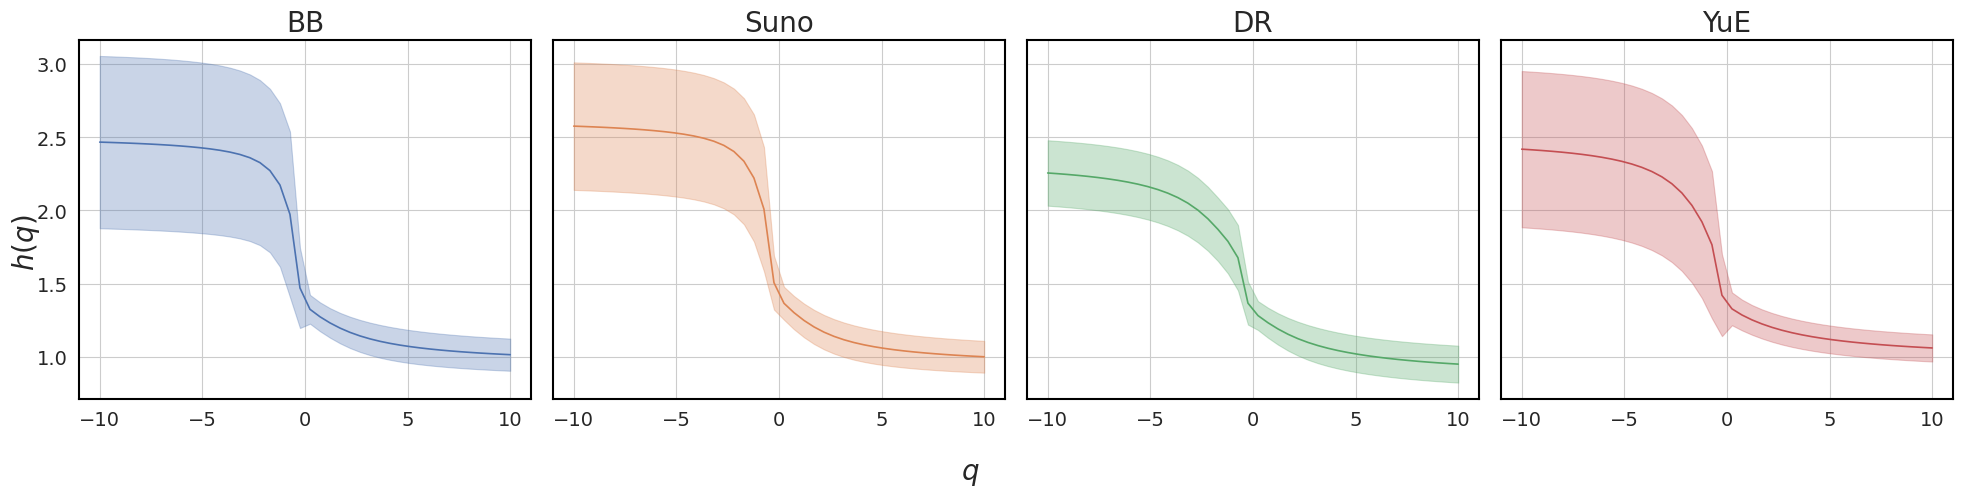

In [ ]:
# === Plot H(q) Spectrum Ribbon Plots in a Row ===
models = list(mfdfa_data.keys())  # Define model list
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for ax, model in zip(axs, models):
    data = clean_df[clean_df["model"] == model].copy()
    q = data["q"].to_numpy(dtype=float)
    mean = data["Hq_mean"].to_numpy(dtype=float)
    std = data["Hq_std"].to_numpy(dtype=float)

    color = palette[model]
    ax.plot(q, mean, label=f"{model}", color=color)
    ax.fill_between(q, mean - std, mean + std, alpha=0.3, color=color)

    ax.set_title(f"{model}", fontsize=20)
    ax.set_xticks(np.linspace(-10, 10, 5))  # Reduce number of x ticks
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Surround plot with black box
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(1.5)

# Unified x and y labels
fig.supxlabel(r"$q$", fontsize=20)
fig.supylabel(r"$h(q)$", fontsize=20)

plt.tight_layout()
plt.show()

In [42]:
# This compares song-by-song and then averages RMSE, preserving per-track information before aggregating.
# The results make all models seem much worse
def compute_rmse(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    return mean_squared_error(p, q)

def rmse_by_qrange(billboard_df, model_df, q_ranges, decades):
    rmse_results = {k: {} for k in q_ranges}

    for decade in decades:
        bb_decade = billboard_df[billboard_df["decade"] == decade].copy()
        model_decade = model_df[model_df["decade"] == decade].copy()

        # Filter out invalid rows
        bb_decade = bb_decade[bb_decade["H_q"].apply(lambda x: isinstance(x, (list, np.ndarray)))]
        model_decade = model_decade[model_decade["H_q"].apply(lambda x: isinstance(x, (list, np.ndarray)))]

        if bb_decade.empty or model_decade.empty:
            for k in rmse_results:
                rmse_results[k][decade] = np.nan
            continue

        try:
            bb_H = np.stack(bb_decade["H_q"].to_list())
            model_H = np.stack(model_decade["H_q"].to_list())
        except Exception as e:
            print(f"Error stacking H_q for decade {decade}: {e}")
            for k in rmse_results:
                rmse_results[k][decade] = np.nan
            continue

        min_len = min(len(bb_H), len(model_H))
        bb_H = bb_H[:min_len]
        model_H = model_H[:min_len]

        for label, indices in q_ranges.items():
            bb_vals = bb_H[:, indices]
            model_vals = model_H[:, indices]
            per_song_rmses = [compute_rmse(bb, model) for bb, model in zip(bb_vals, model_vals)]
            rmse_results[label][decade] = np.mean(per_song_rmses)

    return rmse_results

In [43]:
# === RMSE Calculation ===
# average H(q) curve across all songs in a decade, but only within the selected q-range
def compute_rmse(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    return np.sqrt(mean_squared_error(p, q))

def rmse_by_qrange(billboard_df, model_df, q_ranges, decades):
    rmse_results = {k: {} for k in q_ranges}
    for decade in decades:
        bb_decade = billboard_df[billboard_df["decade"] == decade]
        model_decade = model_df[model_df["decade"] == decade]
        if bb_decade.empty or model_decade.empty:
            for k in rmse_results:
                rmse_results[k][decade] = np.nan
            continue
        bb_H = np.stack(bb_decade["H_q"].to_list())
        model_H = np.stack(model_decade["H_q"].to_list())
        for label, indices in q_ranges.items():
            bb_vals = bb_H[:, indices].mean(axis=0)
            model_vals = model_H[:, indices].mean(axis=0)
            rmse = compute_rmse(bb_vals, model_vals)
            rmse_results[label][decade] = rmse
    return rmse_results

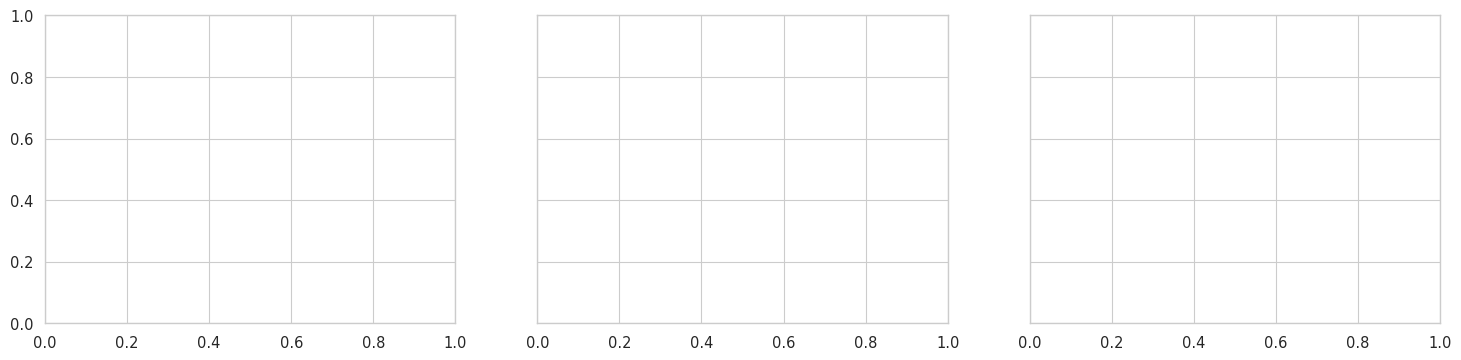

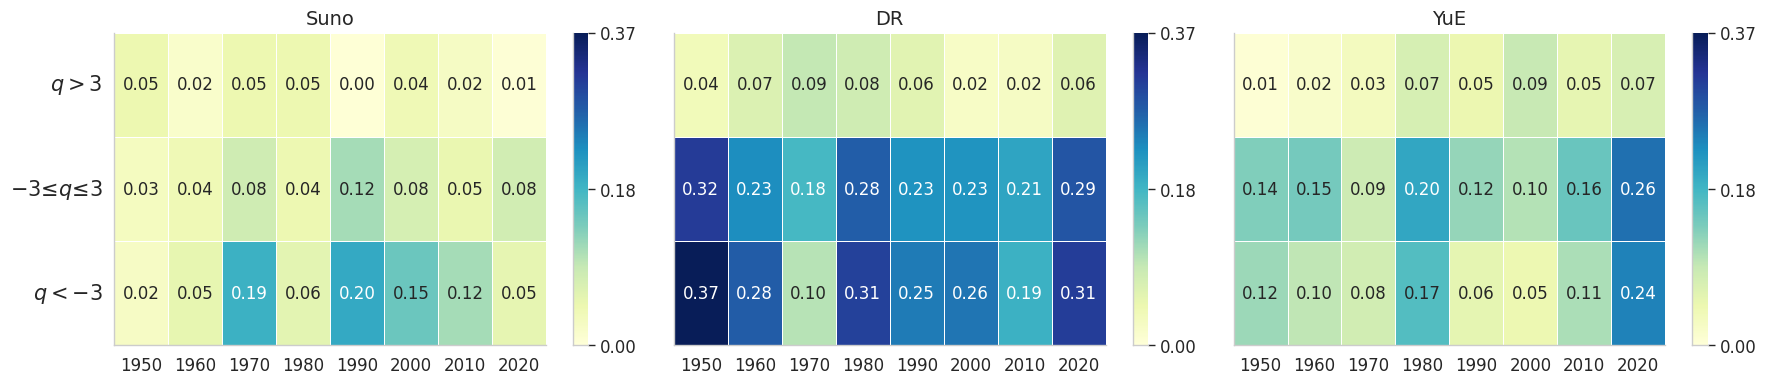

In [ ]:
# === Compute per-model RMSEs ===
def add_decade(df):
    df["decade"] = (df["year"] // 10 * 10).astype(int)
    return df

billboard_copy = add_decade(billboard.copy())
suno_copy = add_decade(suno.copy())
diffrhythm_copy = add_decade(diffrhythm.copy())
yue_copy = add_decade(yue.copy())

qvals = np.linspace(-10, 10, 42)
low_q_indices = np.where(qvals < -3)[0].tolist()
mid_q_indices = np.where((qvals >= -3) & (qvals <= 3))[0].tolist()
high_q_indices = np.where(qvals > 3)[0].tolist()

q_ranges = {
    r"$q > 3$": high_q_indices,
    r"$-3 ≤ q ≤ 3$": mid_q_indices,
    r"$q < -3$": low_q_indices
}

decades = sorted(billboard_copy["decade"].unique())
kl_suno = rmse_by_qrange(billboard_copy, suno_copy, q_ranges, decades)
kl_diff = rmse_by_qrange(billboard_copy, diffrhythm_copy, q_ranges, decades)
kl_yue = rmse_by_qrange(billboard_copy, yue_copy, q_ranges, decades)

# === Create DataFrames for each model ===
kl_df_suno = pd.DataFrame(kl_suno).T
kl_df_diff = pd.DataFrame(kl_diff).T
kl_df_yue = pd.DataFrame(kl_yue).T

# === Determine shared color scale ===
vmin = min(kl_df_suno.min().min(), kl_df_diff.min().min(), kl_df_yue.min().min())
vmax = max(kl_df_suno.max().max(), kl_df_diff.max().max(), kl_df_yue.max().max())

# === Plot heatmaps with consistent styling ===
fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

# Set shared color scale and ticks
limit = max(abs(vmin), abs(vmax))
vmin, vmax = 0, limit
mid = (vmin + vmax) / 2
ticks = [vmin, mid, vmax]

# Titles to match formatting
titles = ["Suno", "DR", "YuE"]
fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

limit = max(abs(vmin), abs(vmax))
vmin, vmax = 0, limit
mid = (vmin + vmax) / 2
ticks = [vmin, mid, vmax]

for ax, data, title in zip(axs, [kl_df_suno, kl_df_diff, kl_df_yue], titles):
    heatmap = sns.heatmap(
        data, ax=ax, cmap="YlGnBu", annot=True, fmt=".2f",
        linewidths=0.5, annot_kws={"size": 12},
        cbar_kws={"shrink": 1.0}, vmin=vmin, vmax=vmax
    )

    # Colorbar settings
    cbar = heatmap.collections[0].colorbar
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{ticks[0]:.2f}", f"{ticks[1]:.2f}", f"{ticks[2]:.2f}"])
    cbar.ax.tick_params(labelsize=12)

    # Fix y-axis bin labels
    ax.set_yticks([0.5, 1.5, 2.5])
    ax.set_yticklabels(list(q_ranges.keys()), fontsize=15, rotation=0)

    # Axis formatting
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()